# Load dataset to train example model

Add [this Google folder](https://drive.google.com/drive/folders/1K54qqwYtk1ADJlkptJNF-FfyjQ7R6KGC?usp=sharing) to your drive then adjust the paths in the `current_directory` variable 

In [ ]:
import warnings
warnings.filterwarnings("ignore")

from google.colab import drive
import os
drive.mount('/content/drive')

In [ ]:
current_directory = "/content/drive/MyDrive/AI/Trained models"
os.chdir("/content/drive/MyDrive/AI/Trained models")

In [2]:
import pandas as pd

In [75]:
df = pd.read_csv("Perplexity.csv", encoding="latin1")
df.dropna(inplace=True)
df['Mean Perplexity'] = df['Mean Perplexity'].astype(float)
print(len(df))
df.head(1)

15979


,question,Raw_Text,Text,Label,Mean Perplexity
0,What are squatter 's rights in California and ...,Adverse possession far predates the formation ...,adverse possession far predates formation u ho...,0,98.381706


Ensure that there is no skew in the dataset

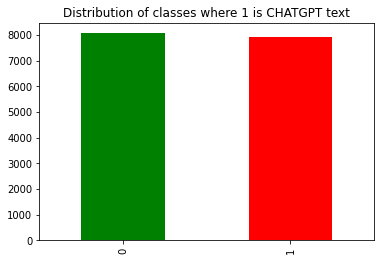

In [51]:
import matplotlib.pyplot as plt

count_Class=pd.value_counts(df["Label"], sort= True)
count_Class.plot(kind = 'bar',color = ["green","red"])
plt.title('Distribution of classes where 1 is CHATGPT text')
plt.show()

# Experiment: Text + Perplexity Column with Keras LSTM

Accuracy: 73%

In [ ]:
!pip install tensorflow_text

In [53]:
import tensorflow as tf
import numpy as np
import tensorflow_hub as hub
import tensorflow_text as text
from sklearn.model_selection import train_test_split

In [54]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

Define the model layers
- We are using BERT embeddings as text input
- We are also taking in a numeric column so we will concatenate two neural networks to get the final prediction

In [55]:
# Define the BERT model
BERT_MODEL = "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1" 
# Choose the preprocessing that must match the model
PREPROCESS_MODEL = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"

preprocess = hub.load(PREPROCESS_MODEL)
bert = hub.load(BERT_MODEL)

# create model -- numeric features in this e.g. are mean perplexity
numeric_col_count = 1
numeric_input_layer = tf.keras.layers.Input(shape=(numeric_col_count,))
numeric_dense_layer_4 = tf.keras.layers.Dense(64, activation='relu')(numeric_input_layer)

# second input model
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessing_layer = hub.KerasLayer(PREPROCESS_MODEL, name='preprocessing')
encoder_inputs = preprocessing_layer(text_input)
encoder = hub.KerasLayer(BERT_MODEL, trainable=True, name='BERT_encoder')
outputs = encoder(encoder_inputs)
net = outputs['sequence_output']
net = tf.keras.layers.Dropout(0.1)(net)
net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True))(net)
lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32))(net)
lstm_dense = tf.keras.layers.Dense(64, activation='relu')(lstm)

# merge input models
merge = tf.keras.layers.concatenate([lstm_dense, numeric_dense_layer_4])

# interpretation model
hidden1 = tf.keras.layers.Dense(32, activation='relu')(merge)
hidden2 = tf.keras.layers.Dense(10, activation='relu')(hidden1)
output = tf.keras.layers.Dense(1, activation='sigmoid')(hidden2)
rnn_model = tf.keras.models.Model(inputs=[numeric_input_layer, text_input], outputs=output)

rnn_model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy', tf.keras.metrics.FalsePositives()])

Train the model
- Early stopping included to prevent overfitting

In [76]:
import numpy as np
X = df[["Mean Perplexity","Raw_Text"]]
y = df['Label'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)


# define scaler
from pickle import dump
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
# fit scaler on the training dataset
scaler.fit(np.array(X_train["Mean Perplexity"]).reshape(-1,1))
X_train["Mean Perplexity"] = scaler.transform(np.array(X_train["Mean Perplexity"]).reshape(-1,1)) 
X_test["Mean Perplexity"] = scaler.transform(np.array(X_test["Mean Perplexity"]).reshape(-1,1))  
dump(scaler, open('scaler.pkl', 'wb'))
X_train.head()


,Mean Perplexity,Raw_Text
12400,0.037384,Hey OP . This [ NOVA ] ( URL_0 ) Q & A may be ...
2484,0.005753,Sure! An imaginary number is a number that can...
12164,0.000950,"Sour candies contain citric acid, which can be..."
6092,0.000510,Fascism is a type of government where one pers...
4590,0.003798,"Being a Nazi , displaying Nazi symbols , etc i..."


In [77]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=1)
history = rnn_model.fit([np.asarray(X_train["Mean Perplexity"].values).astype('float32'), X_train["Raw_Text"].values], y_train, epochs=10, verbose=True, validation_split=0.3, batch_size=32,callbacks=[early_stop])

Epoch 1/10
245/245 [==============================] - 2138s 9s/step - loss: 0.6932 - accuracy: 0.5063 - false_positives: 1419.0000 - val_loss: 0.6936 - val_accuracy: 0.5024 - val_false_positives: 0.0000e+00
Epoch 2/10
245/245 [==============================] - 1849s 8s/step - loss: 0.6924 - accuracy: 0.5211 - false_positives: 414.0000 - val_loss: 0.6916 - val_accuracy: 0.5024 - val_false_positives: 0.0000e+00
Epoch 3/10
245/245 [==============================] - 1998s 8s/step - loss: 0.6882 - accuracy: 0.5495 - false_positives: 803.0000 - val_loss: 0.6801 - val_accuracy: 0.5024 - val_false_positives: 0.0000e+00
Epoch 4/10
245/245 [==============================] - 2041s 8s/step - loss: 0.6501 - accuracy: 0.6512 - false_positives: 1136.0000 - val_loss: 0.5840 - val_accuracy: 0.8030 - val_false_positives: 556.0000
Epoch 5/10
245/245 [==============================] - 1981s 8s/step - loss: 0.5113 - accuracy: 0.8188 - false_positives: 1054.0000 - val_loss: 0.4213 - val_accuracy: 0.7926 - v

Evaluate the model
- Model tends to predict human as AI more (false positive) as compared to AI as human (false negative)

In [78]:
rnn_model.evaluate([X_test["Mean Perplexity"], X_test['Raw_Text']], y_test, verbose=False)

[0.24544523656368256, 0.9207342267036438, 143.0]

150/150 [==============================] - 234s 2s/step


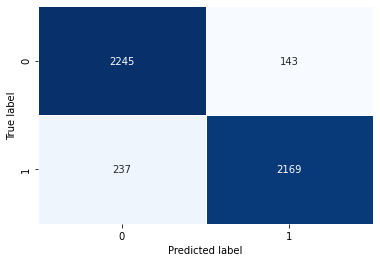

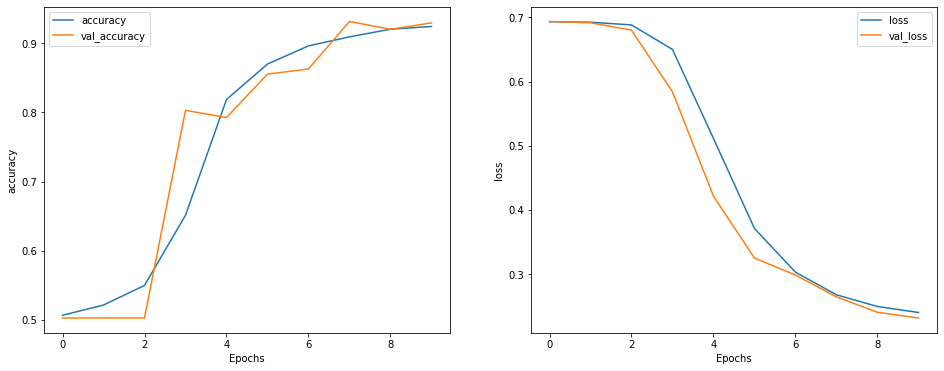

In [79]:
def plot_confusion_matrix(y_true, y_pred):
   mtx = confusion_matrix(y_true, y_pred)
   sns.heatmap(mtx, annot=True, fmt='d', linewidths=.5, 
               cmap="Blues", cbar=False)
   plt.ylabel('True label')
   plt.xlabel('Predicted label')


def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

cont_preds = rnn_model.predict([X_test["Mean Perplexity"], X_test['Raw_Text']])
preds = (cont_preds > 0.5).astype("int32")
plot_confusion_matrix(y_test, preds)

plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

In [80]:
#save model
import os
import tensorflow as tf
current_directory = os.getcwd()
rnn_model.save("rnn_features_model_scaled.h5",save_format = "h5")

In [81]:
import tensorflow as tf
saved_model = tf.keras.models.load_model("rnn_features_model_scaled.h5",custom_objects={'KerasLayer':hub.KerasLayer})
cont_preds = saved_model.predict([X_test["Mean Perplexity"], X_test['Raw_Text']])

150/150 [==============================] - 265s 2s/step


# Experiment: Text + Perplexity Column -- AutoKeras

To find ways to improve the accuracy, I experimented with AutoKeras to try different neural networks. 

The best model after 15 models was a Convolutional Neural Network with accuracy: 0.9470 - auc: 0.9742

In [ ]:
!pip install git+https://github.com/keras-team/keras-tuner.git
!pip install autokeras

In [ ]:
import autokeras as ak

Prepare data

In [ ]:
from sklearn.model_selection import train_test_split
X = df[["Raw_Text","Mean Perplexity"]]
y = df['Label'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

Prepare neural network structure to take in text and numeric input, concatenate the two neural networks from the different layers and produce a regression output

In [ ]:
#For diversity in ensemble models, transformers and ngrams will not be used in the text block
#Pretrained embeddings e.g. glove, word2vec or fasttext is automatically tuned 
input_node_structured = ak.StructuredDataInput()
output_node_structured = ak.DenseBlock()(input_node_structured)

input_node_text = ak.TextInput()
output_node_text = ak.TextBlock(block_type='vanilla')(input_node_text)

output_node_merged = ak.Merge()([output_node_structured, output_node_text])
final_node = ak.RegressionHead(metrics=["accuracy","AUC"])(output_node_merged)

reg = ak.AutoModel(
   inputs=[input_node_structured, input_node_text],
   outputs=[final_node],
   max_trials=10,
)
reg.fit([X_train[["Mean Perplexity"]],X_train["Raw_Text"].to_numpy()], y_train, validation_split=0.15)

Trial 26 Complete [00h 02m 06s]
val_loss: 0.033185090869665146

Best val_loss So Far: 0.030185863375663757
Total elapsed time: 00h 02m 07s
Epoch 1/10
350/350 [==============================] - 16s 38ms/step - loss: 0.0960 - accuracy: 0.8737 - auc: 0.9470
Epoch 2/10
350/350 [==============================] - 4s 12ms/step - loss: 0.0433 - accuracy: 0.9477 - auc: 0.9859
Epoch 3/10
350/350 [==============================] - 3s 8ms/step - loss: 0.0327 - accuracy: 0.9622 - auc: 0.9901
Epoch 4/10
350/350 [==============================] - 3s 9ms/step - loss: 0.0255 - accuracy: 0.9711 - auc: 0.9930
Epoch 5/10
350/350 [==============================] - 3s 8ms/step - loss: 0.0202 - accuracy: 0.9780 - auc: 0.9949
Epoch 6/10
350/350 [==============================] - 4s 11ms/step - loss: 0.0177 - accuracy: 0.9820 - auc: 0.9960
Epoch 7/10
350/350 [==============================] - 3s 10ms/step - loss: 0.0150 - accuracy: 0.9846 - auc: 0.9965
Epoch 8/10
350/350 [==============================] - 3s 9

Evaluate the model

In [ ]:
# Predict with the best model.
predicted_y = reg.predict([X_test[["Mean Perplexity"]],X_test["Raw_Text"].to_numpy()])
# Evaluate the best model with testing data.
print(reg.evaluate([X_test[["Mean Perplexity"]],X_test["Raw_Text"].to_numpy()], y_test))

150/150 [==============================] - 1s 5ms/step - loss: 0.0454 - accuracy: 0.9470 - auc: 0.9742
[0.045413970947265625, 0.9470171332359314, 0.9741848111152649]


Export model

In [ ]:
# Export as a Keras Model.
model = reg.export_model()
model.summary()
try:
    model.save("model_autokeras_vanilla", save_format="tf")
except Exception:
    model.save("model_autokeras_vanilla.h5")

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 expand_last_dim (ExpandLastDim  (None, 1)           0           ['input_2[0][0]']                
 )                                                                                                
                                                                                                  
 text_vectorization (TextVector  (None, 64)          0           ['expand_last_dim[0][0]']        
 ization)                                                                                         
                                                                                              

Load model to check if it works 

In [ ]:
import tensorflow as tf
loaded_model = tf.keras.models.load_model("model_autokeras_vanilla", custom_objects=ak.CUSTOM_OBJECTS)
predicted_y = loaded_model.predict([X_test[["Mean Perplexity"]],X_test["Raw_Text"].to_numpy()])
print(predicted_y)

# Experiment: Text -- AutoKeras

The best model after trying 5 models was a Convolutional Neural Network with 
accuracy: 0.9821 - auc: 0.9925

Less models were tried because each trial took a lot of memory and time

In [ ]:
!pip install git+https://github.com/keras-team/keras-tuner.git
!pip install autokeras

In [ ]:
import autokeras as ak

This dataset has more datapoints than the perplexity one. Perplexity takes a long time to scrape so we trained on as much data point as we could scrape.

In [ ]:
import pandas as pd
df = pd.read_csv("eli5_clean_combined.csv")
df.dropna(inplace = True)
df.head(1)

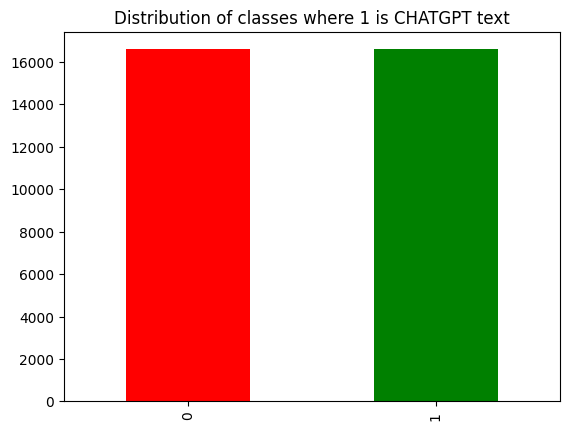

In [ ]:
import matplotlib.pyplot as plt
count_Class=pd.value_counts(df["Label"], sort= True)
count_Class.plot(kind = 'bar',color = ["green","red"])
plt.title('Distribution of classes where 1 is CHATGPT text')
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split
X = df[["response"]]
y = df['Label'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

Train model

In [ ]:
reg = ak.TextRegressor(overwrite=True, max_trials=5, metrics=["accuracy","AUC"])
reg.fit(X_train["response"].to_numpy(), y_train, validation_split=0.15)

Trial 5 Complete [00h 04m 41s]
val_loss: 0.014697384089231491

Best val_loss So Far: 0.012621596455574036
Total elapsed time: 00h 28m 21s
Epoch 1/17
726/726 [==============================] - 49s 62ms/step - loss: 0.0961 - accuracy: 0.8896 - auc: 0.9510
Epoch 2/17
726/726 [==============================] - 9s 12ms/step - loss: 0.0244 - accuracy: 0.9738 - auc: 0.9937
Epoch 3/17
726/726 [==============================] - 7s 10ms/step - loss: 0.0127 - accuracy: 0.9885 - auc: 0.9974
Epoch 4/17
726/726 [==============================] - 8s 10ms/step - loss: 0.0087 - accuracy: 0.9926 - auc: 0.9987
Epoch 5/17
726/726 [==============================] - 9s 12ms/step - loss: 0.0064 - accuracy: 0.9948 - auc: 0.9993
Epoch 6/17
726/726 [==============================] - 9s 12ms/step - loss: 0.0048 - accuracy: 0.9964 - auc: 0.9996
Epoch 7/17
726/726 [==============================] - 8s 11ms/step - loss: 0.0048 - accuracy: 0.9961 - auc: 0.9994
Epoch 8/17
726/726 [==============================] - 9s

Evaluate Model

In [ ]:
# Predict with the best model.
predicted_y = reg.predict(X_test["response"].to_numpy())
# Evaluate the best model with testing data.
print(reg.evaluate(X_test["response"].to_numpy(), y_test))

311/311 [==============================] - 3s 8ms/step - loss: 0.0153 - accuracy: 0.9821 - auc: 0.9925
[0.015286284498870373, 0.9821123480796814, 0.9925251603126526]


Output model

In [ ]:
# Export as a Keras Model.
model = reg.export_model()
model.summary()
try:
    model.save("model_autokeras_vanilla_text_only", save_format="tf")
except Exception:
    model.save("model_autokeras_vanilla_text_only")

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None,)]                 0         
                                                                 
 expand_last_dim (ExpandLast  (None, 1)                0         
 Dim)                                                            
                                                                 
 text_vectorization (TextVec  (None, 128)              0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 128, 128)          640128    
                                                                 
 dropout (Dropout)           (None, 128, 128)          0         
                                                                 
 conv1d (Conv1D)             (None, 126, 32)           12320 

Load Model to check if it can predict

In [ ]:
import tensorflow as tf
loaded_model = tf.keras.models.load_model("model_autokeras_vanilla_text_only", custom_objects=ak.CUSTOM_OBJECTS)
predicted_y = loaded_model.predict(X_test["response"].to_numpy())
print(predicted_y)

311/311 [==============================] - 2s 7ms/step
[[-2.08175331e-02]
 [-1.38656795e-02]
 [-2.81576067e-03]
 ...
 [-2.06542313e-02]
 [ 9.78062987e-01]
 [-8.97668302e-04]]


# Experiment: Text + GLTR Feature -- AutoKeras

The best model after trying 3 models was a Convolutional Neural Network with accuracy: 0.9704 - auc: 0.9986

In [ ]:
!pip install git+https://github.com/keras-team/keras-tuner.git
!pip install autokeras

In [5]:
import autokeras as ak

In [6]:
import pandas as pd
df = pd.read_csv("scraped_gltr_features.csv")[["question","response","label","GLTR Category 1","GLTR Category 3"]]
df.dropna(inplace = True)
df.head(1)

,question,response,label,GLTR Category 1,GLTR Category 3
0,"Why is every book I hear about a "" NY Times # ...",There are many different best seller lists tha...,1.0,0.888412,0.017167


In [7]:
gpt_df = df[df["label"] == 1]
human_df = df[df["label"] == 0][:len(gpt_df)]
processed_df = pd.concat([gpt_df, human_df])

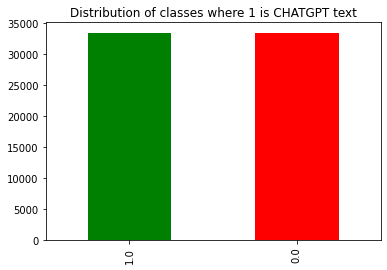

In [8]:
import matplotlib.pyplot as plt
count_Class=pd.value_counts(processed_df["label"], sort= True)
count_Class.plot(kind = 'bar',color = ["green","red"])
plt.title('Distribution of classes where 1 is CHATGPT text')
plt.show()

In [9]:
from sklearn.model_selection import train_test_split
X = processed_df[["response","GLTR Category 1","GLTR Category 3"]]
y = processed_df['label'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [34]:
input_node_structured = ak.StructuredDataInput()
output_node_structured = ak.DenseBlock()(input_node_structured)

input_node_text = ak.TextInput()
output_node_text = ak.TextBlock(block_type='vanilla')(input_node_text)

output_node_merged = ak.Merge()([output_node_structured, output_node_text])
final_node = ak.RegressionHead(metrics=["accuracy","AUC"])(output_node_merged)

reg = ak.AutoModel(overwrite=True,
   inputs=[input_node_structured, input_node_text],
   outputs=[final_node],
   max_trials=8,
)
reg.fit([X_train[["GLTR Category 1","GLTR Category 3"]],X_train["response"].to_numpy()], y_train, validation_split=0.3)

Trial 8 Complete [00h 14m 31s]
val_loss: 0.015043986961245537

Best val_loss So Far: 0.012184125371277332
Total elapsed time: 02h 15m 47s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


Epoch 1/20
1462/1462 [==============================] - 88s 58ms/step - loss: 0.0295 - accuracy: 0.9739 - auc: 0.9928
Epoch 2/20
1462/1462 [==============================] - 82s 56ms/step - loss: 0.0172 - accuracy: 0.9836 - auc: 0.9980
Epoch 3/20
1462/1462 [==============================] - 83s 57ms/step - loss: 0.0129 - accuracy: 0.9895 - auc: 0.9993
Epoch 4/20
1462/1462 [==============================] - 82s 56ms/step - loss: 0.0106 - accuracy: 0.9937 - auc: 0.9996
Epoch 5/20
1462/1462 [==============================] - 82s 56ms/step - loss: 0.0091 - accuracy: 0.9959 - auc: 0.9997
Epoch 6/20
1462/1462 [==============================] - 80s 55ms/step - loss: 0.0080 - accuracy: 0.9959 - auc: 0.9998
Epoch 7/20
1462/1462 [==============================] - 80s 55ms/step - loss: 0.0068 - accuracy: 0.9953 - auc: 0.9998
Epoch 8/20
1462/1462 [==============================] - 82s 56ms/step - loss: 0.0062 - accuracy: 0.9947 - auc: 0.9998
Epoch 9/20
1462/1462 [==============================] - 

INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


In [35]:
# Predict with the best model.
predicted_y = reg.predict([X_test[["GLTR Category 1","GLTR Category 3"]],X_test["response"].to_numpy()])
# Evaluate the best model with testing data.
print(reg.evaluate([X_test[["GLTR Category 1","GLTR Category 3"]],X_test["response"].to_numpy()], y_test))

627/627 [==============================] - 11s 17ms/step - loss: 0.0268 - accuracy: 0.9607 - auc: 0.9973
[0.026763441041111946, 0.9607285261154175, 0.997323215007782]


In [36]:
# Export as a Keras Model.
model = reg.export_model()
model.summary()
try:
    model.save("model_autokeras_gltr_trials_8", save_format="tf")
except Exception:
    model.save("model_autokeras_gltr_trials_8")

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 expand_last_dim (ExpandLastDim  (None, 1)           0           ['input_2[0][0]']                
 )                                                                                                
                                                                                                  
 text_vectorization (TextVector  (None, 64)          0           ['expand_last_dim[0][0]']        
 ization)                                                                                         
                                                                                              

INFO:tensorflow:Assets written to: model_autokeras_gltr_trials_8\assets


INFO:tensorflow:Assets written to: model_autokeras_gltr_trials_8\assets


In [38]:
import tensorflow as tf
loaded_model = tf.keras.models.load_model("model_autokeras_gltr_trials_8", custom_objects=ak.CUSTOM_OBJECTS)
predicted_y = loaded_model.predict([X_test[["GLTR Category 1","GLTR Category 3"]],X_test["response"].to_numpy()])
print(predicted_y)

627/627 [==============================] - 10s 16ms/step
[[0.14909863]
 [0.53583705]
 [1.0175072 ]
 ...
 [1.0302348 ]
 [0.00203642]
 [0.01022002]]


# Holdout Dataset Evaluation of Models

First, the models will be wrapped in a Custom Class so that they can be added into an ensemble later

In [1]:
#For RNN Feature Classifier
!pip install tensorflow_text
!pip install git+https://github.com/keras-team/keras-tuner.git
!pip install autokeras


  Cloning https://github.com/keras-team/keras-tuner.git to c:\users\isabe\appdata\local\temp\pip-req-build-0dydxicq


  Running command git clone --filter=blob:none --quiet https://github.com/keras-team/keras-tuner.git 'C:\Users\isabe\AppData\Local\Temp\pip-req-build-0dydxicq'
  fatal: unable to access 'https://github.com/keras-team/keras-tuner.git/': Could not resolve host: github.com
  error: subprocess-exited-with-error
  
  git clone --filter=blob:none --quiet https://github.com/keras-team/keras-tuner.git 'C:\Users\isabe\AppData\Local\Temp\pip-req-build-0dydxicq' did not run successfully.
  exit code: 128
  
  See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
error: subprocess-exited-with-error

git clone --filter=blob:none --quiet https://github.com/keras-team/keras-tuner.git 'C:\Users\isabe\AppData\Local\Temp\pip-req-build-0dydxicq' did not run successfully.
exit code: 128

See above for output.

note: This error originates from a subprocess, and is likely not a problem with pip.


In [2]:
"""
!pip install tensorflow_text
!pip install git+https://github.com/keras-team/keras-tuner.git
!pip install autokeras
"""
import autokeras as ak

from sklearn.base import BaseEstimator, ClassifierMixin, TransformerMixin
from sklearn.pipeline import Pipeline
from tensorflow.keras.models import load_model

import tensorflow as tf
import numpy as np
import tensorflow_hub as hub
import tensorflow_text as text
from tensorflow.keras.models import load_model

def flatten(l):
    return [item for sublist in l for item in sublist]

def process_output(preds):
    flattened_pred = flatten(preds)
    output = tf.constant(flattened_pred)
    return tf.math.sigmoid(output).numpy().tolist()

class RNNPerplexityClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, path, path_scaler):
        self.scaler = pickle.load(open(path_scaler, 'rb'))
        self.model=load_model(path,custom_objects={'KerasLayer':hub.KerasLayer})
    
    def predict(self, X, y=None):
        processed_X = self.process(X)
        return process_output(self.model.predict(processed_X))

    #Add any custom transformers as needed to produce the X input format your model needs 
    def process(self, X, y=None):
        X_copy = X.copy()
        X_copy["Mean Perplexity"] = scaler.transform(np.array(X_copy["Mean Perplexity"]).reshape(-1,1))
        output = [np.asarray(X_copy["Mean Perplexity"].values).astype('float32'), X_copy["response"].values]
        return output

class CNNPerplexityClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, path):
        self.model=load_model(path,custom_objects=ak.CUSTOM_OBJECTS)
    
    def predict(self, X, y=None):
        processed_X = self.process(X)
        return process_output(self.model.predict(processed_X))

    #Add any custom transformers as needed to produce the X input format your model needs 
    def process(self, X, y=None):
        output = [X[["Mean Perplexity"]],X["response"].to_numpy()]
        return output

class CNNGLTRClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, path):
        self.model=load_model(path,custom_objects=ak.CUSTOM_OBJECTS)
    
    def predict(self, X, y=None):
        processed_X = self.process(X)
        return process_output(self.model.predict(processed_X))
    
    #Add any custom transformers as needed to produce the X input format your model needs 
    def process(self, X, y=None):
        output = [X[["GLTR Category 1","GLTR Category 3"]],X["response"].to_numpy()]
        return output

class CNNTextClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, path):
        self.model=load_model(path,custom_objects=ak.CUSTOM_OBJECTS)
    
    def predict(self, X, y=None):
        processed_X = self.process(X)
        return process_output(self.model.predict(processed_X))
    
    #Add any custom transformers as needed to produce the X input format your model needs 
    def process(self, X, y=None):
        output = X["response"].to_numpy()
        return output

In [ ]:
import pickle
from pickle import load
rnn_perplexity_classifier = RNNPerplexityClassifier("rnn_features_model_scaled.h5", "scaler.pkl")
cnn_gltr_classifier = CNNGLTRClassifier("model_autokeras_gltr_trials_8")
cnn_perplexity_classifier = CNNPerplexityClassifier(current_directory+"/model_autokeras_vanilla")
cnn_text_classifier = CNNTextClassifier(current_directory+"/model_autokeras_vanilla_text_only")

Load holdout data and Normalise the columns


*   GLTR, Subjectivity is from 0 to 1



In [16]:
import pandas as pd
df = pd.read_csv("holdout_with_features.csv", encoding="latin1")
df.dropna(inplace=True)
print(len(df))
df.head(1)

9998


,response,Label,GLTR Category 1,GLTR Category 3,sum_mistakes,TextBlob_Subjectivity,Formality Score
0,"We don't exactly know, but there are some good...",0.0,0.675127,0.045685,2,0.55911,66.129032


In [17]:
X = df.drop("Label",axis=1)
y = df['Label'].values

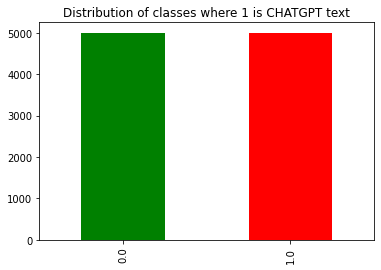

In [18]:
import matplotlib.pyplot as plt
count_Class=pd.value_counts(df["Label"], sort= True)
count_Class.plot(kind = 'bar',color = ["green","red"])
plt.title('Distribution of classes where 1 is CHATGPT text')
plt.show()

Get Predictions

In [9]:
from sklearn.metrics import classification_report,accuracy_score,f1_score,roc_auc_score  

def evaluate(pred, y_true, threshold):
  y_pred = np.array(pred)
  discrete = (y_pred > threshold).astype("int32")
  print(f"Accuracy: {accuracy_score(y,discrete)}")
  print(f"F1: {f1_score(y,discrete)}")
  print(f"ROC_AUC: {roc_auc_score(y, discrete)}")
  print(classification_report(discrete, y, target_names=["Human", "ChatGPT"]))

In [103]:
rnn_prediction_output = rnn_perplexity_classifier.predict(X)
print(rnn_prediction_output)

63/63 [==============================] - 121s 2s/step
[0.534501314163208, 0.5541765093803406, 0.6031655669212341, 0.6157630681991577, 0.5016422271728516, 0.5669768452644348, 0.5684290528297424, 0.55460524559021, 0.6762598156929016, 0.5732190012931824, 0.6748241782188416, 0.6525423526763916, 0.5252470374107361, 0.5074205994606018, 0.6482102274894714, 0.6738503575325012, 0.54572993516922, 0.7022880911827087, 0.7087754011154175, 0.5020495057106018, 0.5464333891868591, 0.6624442934989929, 0.5150589942932129, 0.5770308375358582, 0.5909184217453003, 0.6896339654922485, 0.6138420104980469, 0.703224778175354, 0.700749933719635, 0.5165201425552368, 0.6002991199493408, 0.5032476782798767, 0.5532737970352173, 0.5120661854743958, 0.5472753643989563, 0.536686897277832, 0.5430112481117249, 0.6648132801055908, 0.6449872255325317, 0.6247196197509766, 0.5583117604255676, 0.6229626536369324, 0.6571893692016602, 0.5592857599258423, 0.5405129790306091, 0.5482180714607239, 0.5045838356018066, 0.55912446975

In [104]:
print("RNN Perplexity Classifier")
evaluate(rnn_prediction_output, y, 0.6)

RNN Perplexity Classifier
Accuracy: 0.821
F1: 0.8477891156462585
ROC_AUC: 0.821
              precision    recall  f1-score   support

       Human       0.65      1.00      0.78       648
     ChatGPT       1.00      0.74      0.85      1352

    accuracy                           0.82      2000
   macro avg       0.82      0.87      0.82      2000
weighted avg       0.88      0.82      0.83      2000



In [ ]:
cnn_perplexity_prediction_output = cnn_perplexity_classifier.predict(X)
print(cnn_perplexity_prediction_output)

63/63 [==============================] - 5s 8ms/step
[0.5014101266860962, 0.49890851974487305, 0.6284050345420837, 0.5033547282218933, 0.4994478225708008, 0.7302818298339844, 0.49853065609931946, 0.49594125151634216, 0.6753624677658081, 0.5045560002326965, 0.5040003657341003, 0.5789883732795715, 0.49966707825660706, 0.49338415265083313, 0.6697843074798584, 0.501882016658783, 0.5236969590187073, 0.5004755854606628, 0.5042434930801392, 0.4972739517688751, 0.4981280565261841, 0.5058361291885376, 0.4950283467769623, 0.4988974928855896, 0.5014936923980713, 0.5102274417877197, 0.49767324328422546, 0.5035402774810791, 0.5026661157608032, 0.49792346358299255, 0.4979252219200134, 0.5000495314598083, 0.5053633451461792, 0.49881845712661743, 0.5027081966400146, 0.49451637268066406, 0.4991874694824219, 0.4962420165538788, 0.4985453486442566, 0.6771114468574524, 0.7366238832473755, 0.524073600769043, 0.5073763728141785, 0.4959869682788849, 0.49489226937294006, 0.6958396434783936, 0.5868621468544006

In [ ]:
print("CNN Perplexity Classifier")
evaluate(cnn_perplexity_prediction_output, y, 0.6)

CNN Perplexity Classifier
Accuracy: 0.793
F1: 0.7845993756503641
ROC_AUC: 0.7947935237987919
              precision    recall  f1-score   support

       Human       0.83      0.77      0.80      1078
     ChatGPT       0.75      0.82      0.78       922

    accuracy                           0.79      2000
   macro avg       0.79      0.79      0.79      2000
weighted avg       0.80      0.79      0.79      2000



In [19]:
cnn_gltr_prediction_output = cnn_gltr_classifier.predict(X)
print(cnn_gltr_prediction_output)

313/313 [==============================] - 4s 14ms/step
[0.5050675868988037, 0.7337952256202698, 0.50079345703125, 0.7317712306976318, 0.49452948570251465, 0.7355908155441284, 0.6334221959114075, 0.7305535078048706, 0.7235416173934937, 0.7118577361106873, 0.7308946251869202, 0.5319964289665222, 0.6972798705101013, 0.7337028384208679, 0.703262984752655, 0.49970927834510803, 0.7253201603889465, 0.727218508720398, 0.7370782494544983, 0.4981735348701477, 0.4996785521507263, 0.7021787166595459, 0.5019441246986389, 0.4990313649177551, 0.7246415019035339, 0.7054855823516846, 0.7063658833503723, 0.7377186417579651, 0.7034016251564026, 0.4977579116821289, 0.7361698746681213, 0.7031199336051941, 0.7053592205047607, 0.6460078954696655, 0.7292850613594055, 0.6821516752243042, 0.4961388111114502, 0.73617023229599, 0.7272384762763977, 0.5069104433059692, 0.7260153293609619, 0.5012209415435791, 0.7341434359550476, 0.7061889171600342, 0.7066395878791809, 0.6700775027275085, 0.4986591935157776, 0.71297

In [20]:
print("CNN GLTR Classifier")
evaluate(cnn_gltr_prediction_output, y, 0.6)

CNN GLTR Classifier
Accuracy: 0.8273654730946189
F1: 0.835179526355997
ROC_AUC: 0.8273654730946189
              precision    recall  f1-score   support

       Human       0.78      0.86      0.82      4525
     ChatGPT       0.87      0.80      0.84      5473

    accuracy                           0.83      9998
   macro avg       0.83      0.83      0.83      9998
weighted avg       0.83      0.83      0.83      9998



In [22]:
df_output = df.copy()
df_output["CNN_GLTR"] = cnn_gltr_prediction_output
print(len(df_output))
df_output

9998


,response,Label,GLTR Category 1,GLTR Category 3,sum_mistakes,TextBlob_Subjectivity,Formality Score,CNN_GLTR
0,"We don't exactly know, but there are some good...",0.0,0.675127,0.045685,2,0.559110,66.129032,0.505068
1,It is highly unlikely that quarantining indivi...,1.0,0.832298,0.043478,4,0.460750,76.288660,0.733795
2,The neutral radio voice was a requirement in H...,0.0,0.556701,0.092784,6,0.400000,75.925926,0.500793
3,"However, here's a general overview of the glob...",1.0,0.788462,0.048077,9,0.388247,82.642487,0.731771
4,There is a program to give poor folks phones. ...,0.0,0.669565,0.086957,0,0.288584,67.424242,0.494529
...,...,...,...,...,...,...,...,...
9994,"When you are tired, your eyes tend to blink le...",1.0,0.752577,0.041237,8,0.519444,69.000000,0.722273
9995,"Some metals, such as those with sharp edges or...",1.0,0.633803,0.098592,6,0.660714,72.619048,0.502656
9996,"Therefore, I cannot say anything about Faceboo...",1.0,0.666667,0.046296,6,0.411806,71.538462,0.696369
9997,There are several methods that scientists use ...,1.0,0.845865,0.026316,24,0.466255,82.352941,0.736764


In [ ]:
cnn_text_prediction_output = cnn_text_classifier.predict(X)
print(cnn_text_prediction_output)

63/63 [==============================] - 1s 7ms/step
[0.648621141910553, 0.4984554350376129, 0.5935510396957397, 0.49741244316101074, 0.4975477457046509, 0.4963958263397217, 0.4948352873325348, 0.49515774846076965, 0.7271483540534973, 0.5002671480178833, 0.4965860843658447, 0.564044177532196, 0.5039076805114746, 0.49853089451789856, 0.5512794852256775, 0.4979524314403534, 0.7279283404350281, 0.4975771903991699, 0.6095284819602966, 0.5031675696372986, 0.49731171131134033, 0.49766218662261963, 0.6608642935752869, 0.4997081160545349, 0.5012992024421692, 0.4998995363712311, 0.49646320939064026, 0.49596670269966125, 0.4956147074699402, 0.4978005290031433, 0.503876268863678, 0.49725568294525146, 0.49541717767715454, 0.49758508801460266, 0.4973955750465393, 0.49546027183532715, 0.49852052330970764, 0.614133894443512, 0.49707087874412537, 0.5043337345123291, 0.4962110221385956, 0.4992735683917999, 0.49838316440582275, 0.5006017684936523, 0.49925342202186584, 0.49856171011924744, 0.529613554477

In [ ]:
print("CNN Text Classifier")
evaluate(cnn_text_prediction_output, y, 0.6)

CNN Text Classifier
Accuracy: 0.787
F1: 0.7664473684210527
ROC_AUC: 0.7961742949607027
              precision    recall  f1-score   support

       Human       0.88      0.74      0.80      1176
     ChatGPT       0.70      0.85      0.77       824

    accuracy                           0.79      2000
   macro avg       0.79      0.80      0.79      2000
weighted avg       0.80      0.79      0.79      2000



In [ ]:
df_with_preds = df.copy()
df_with_preds["RNNPerplexityClassifier_Predictions"] = rnn_prediction_output
df_with_preds["CNNPerplexityClassifier_Predictions"] = cnn_perplexity_prediction_output
df_with_preds["CNNGLTRClassifer_Predictions"] = cnn_gltr_prediction_output
df_with_preds["CNNTextClassifier_Predictions"] = cnn_text_prediction_output
df_with_preds.head(3)

,response,Label,GLTR Category 1,GLTR Category 3,Mean Perplexity,sum_mistakes,TextBlob_Subjectivity,Formality Score,RNNPerplexityClassifier_Predictions,CNNPerplexityClassifier_Predictions,CNNGLTRClassifer_Predictions,CNNTextClassifier_Predictions
0,Hyperinflation comes almost always because of ...,0,0.605442,0.112245,0.034284,0.058824,0.417597,0.671505,0.516926,0.501410,0.498863,0.648621
1,scientists tested whether or not coffee ground...,0,0.679012,0.074074,0.023811,0.078431,0.484375,0.724650,0.525457,0.498909,0.695503,0.498455
2,Because its your body's natural reflex to retu...,0,0.589041,0.136986,0.017898,0.098039,0.425000,0.523077,0.535882,0.628405,0.699814,0.593551


In [ ]:
df.to_csv("holdout_with_features_normalised.csv", index=False)

In [ ]:
df_with_preds.to_csv("holdout_output_keras_models.csv",index=False)

# Make sure can work in Ensemble

In [ ]:
models = [rnn_perplexity_classifier,cnn_perplexity_classifier,cnn_gltr_classifier,cnn_text_classifier]
ensemble = Ensemble(models)